In [27]:
# 유저 데이터 전처리 small
import pandas as pd
from collections import Counter
from typing import Tuple

# 열 이름 정의
BEHAVIOR_COLUMNS = ['ImpressionID', 'UserID', 'Time', 'History', 'Impressions']

# 클릭된 뉴스 ID 추출 함수
def extract_clicks(df: pd.DataFrame, news_ids: pd.Series) -> pd.DataFrame:
    df = df.dropna(subset=['Impressions'])

    history_ids = df['History'].dropna().str.split().explode()
    impressions = df['Impressions'].str.split().explode().str.split('-')
    impression_df = pd.DataFrame(impressions.tolist(), columns=['news_id', 'clicked'])
    clicked_ids = impression_df[impression_df['clicked'] == '1']['news_id']

    history_counter = Counter(history_ids)
    impression_counter = Counter(clicked_ids)

    rows = []
    for news_id in news_ids:
        h_clicks = history_counter.get(news_id, 0)
        i_clicks = impression_counter.get(news_id, 0)
        rows.append({
            'news_id': news_id,
            'clicks_in_history': h_clicks,
            'clicks_in_impressions': i_clicks,
            'total_clicks': h_clicks + i_clicks
        })

    click_df = pd.DataFrame(rows)
    return click_df.sort_values(by='total_clicks', ascending=False)

# 저장 함수
def save_to_csv(df: pd.DataFrame, path: str):
    df.to_csv(path, index=False)

# 메인 실행
if __name__ == '__main__':
    train = pd.read_csv('download/MINDsmall_train/behaviors.tsv', sep='\t', names=BEHAVIOR_COLUMNS, header=0)
    dev = pd.read_csv('download/MINDsmall_dev/behaviors.tsv', sep='\t', names=BEHAVIOR_COLUMNS, header=0)
    combined = pd.concat([train, dev], ignore_index=True)

    train_news = pd.read_csv('download/MINDsmall_train/news.tsv', sep='\t', names=['NewsID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL', 'TitleEntities', 'AbstractEntities'])
    test_news = pd.read_csv('download/MINDsmall_dev/news.tsv', sep='\t', names=['NewsID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL', 'TitleEntities', 'AbstractEntities'])
    news_df = pd.concat([train_news, test_news], ignore_index=True)

    all_news_ids = news_df['NewsID'].dropna().unique()

    small_click_result = extract_clicks(combined, all_news_ids)
    print("[전체 클릭 뉴스 수]", len(small_click_result))
    total_click = small_click_result['total_clicks'].sum()
    print("[전체 뉴스 클릭 수]", total_click)

    print("------------------------------------------------------------")
    low_clicks = small_click_result[small_click_result['total_clicks'] < 5]
    print("[클릭 수 5 미만 뉴스 수]", len(low_clicks))
    print("[클릭 수 5 미만 뉴스 %]", round((len(low_clicks)/len(small_click_result)) * 100 , 3))
    print("------------------------------------------------------------")
    low_click = low_clicks['total_clicks'].sum()
    print("[클릭 수 5 미만 뉴스 총 클릭 수]", low_click)
    print("[클릭 수 5 미만 뉴스 %]", round(low_click/total_click * 100 , 3))

    print("------------------------------------------------------------")
    print("[전체 클릭 5미만 제외 뉴스 수]", len(small_click_result)-len(low_clicks))

print(small_click_result)



[전체 클릭 뉴스 수] 65238
[전체 뉴스 클릭 수] 7817854
------------------------------------------------------------
[클릭 수 5 미만 뉴스 수] 32356
[클릭 수 5 미만 뉴스 %] 49.597
------------------------------------------------------------
[클릭 수 5 미만 뉴스 총 클릭 수] 39623
[클릭 수 5 미만 뉴스 %] 0.507
------------------------------------------------------------
[전체 클릭 5미만 제외 뉴스 수] 32882
      news_id  clicks_in_history  clicks_in_impressions  total_clicks
11465    N306              30498                      0         30498
14216  N42620              28034                      0         28034
21466  N45794              22877                      0         22877
2077   N31801              22560                      0         22560
16666  N43142              21536                      0         21536
...       ...                ...                    ...           ...
42937   N2113                  0                      0             0
42933   N8722                  0                      0             0
42932  N32963          

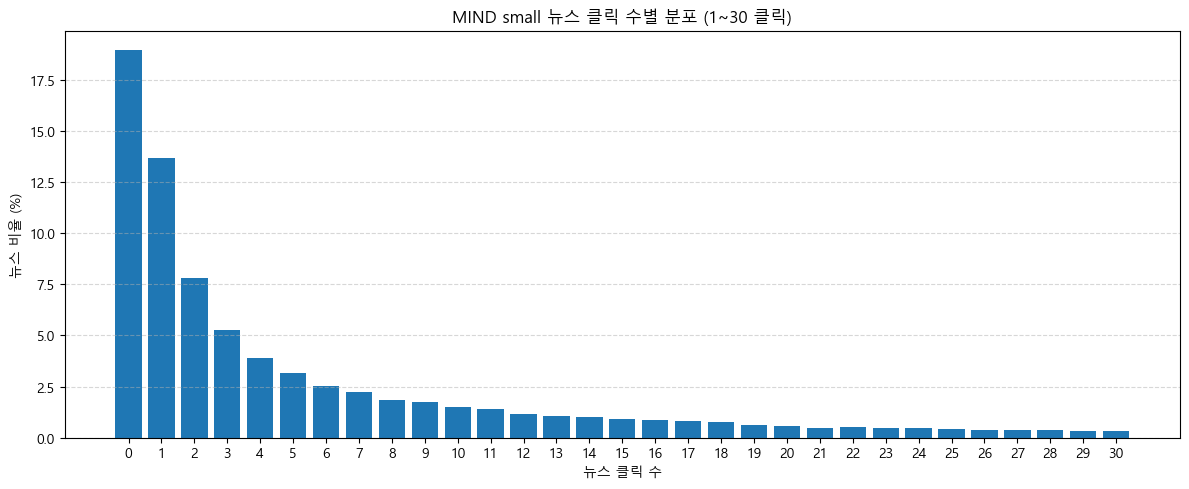

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 폰트 설정
mpl.rc('font', family='Malgun Gothic')  # Windows 기준
mpl.rcParams['axes.unicode_minus'] = False

def plot_full_click_distribution(click_df: pd.DataFrame, max_clicks: int = 30):
    grouped = click_df['total_clicks'].value_counts().sort_index().reset_index()
    grouped.columns = ['click_count', 'news_count']

    total_news = grouped['news_count'].sum()
    grouped['percentage'] = (grouped['news_count'] / total_news) * 100

    grouped = grouped[grouped['click_count'] <= max_clicks]

    plt.figure(figsize=(12, 5))
    plt.bar(grouped['click_count'], grouped['percentage'])
    plt.title(f'MIND small 뉴스 클릭 수별 분포 (1~{max_clicks} 클릭)')
    plt.xlabel('뉴스 클릭 수')
    plt.ylabel('뉴스 비율 (%)')
    plt.xticks(grouped['click_count'])
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_full_click_distribution(small_click_result)

In [17]:
def get_click_0_to_5_percentage(click_df: pd.DataFrame) -> float:
    total_news = len(click_df)
    low_click_news = click_df[click_df['total_clicks'] < 5]
    percentage = (len(low_click_news) / total_news) * 100
    return round(percentage, 3)

def get_click_0_to_10_percentage(click_df: pd.DataFrame) -> float:
    total_news = len(click_df)
    low_click_news = click_df[click_df['total_clicks'] < 10]
    percentage = (len(low_click_news) / total_news) * 100
    return round(percentage, 3)

percent_0_to_5 = get_click_0_to_5_percentage(small_click_result)
print(f"[클릭 수 5 미만 뉴스 비율] {percent_0_to_5}%")
percent_0_to_10 = get_click_0_to_10_percentage(small_click_result)
print(f"[클릭 수 10 미만 뉴스 비율] {percent_0_to_10}%")



[클릭 수 5 미만 뉴스 비율] 49.597%
[클릭 수 10 미만 뉴스 비율] 61.078%


In [2]:
import pandas as pd
from collections import Counter
from typing import Tuple

BEHAVIOR_COLUMNS = ['ImpressionID', 'UserID', 'Time', 'History', 'Impressions']

def extract_clicks(df: pd.DataFrame, news_ids: pd.Series) -> pd.DataFrame:
    df = df.dropna(subset=['Impressions'])

    history_ids = df['History'].dropna().str.split().explode()
    impressions = df['Impressions'].str.split().explode().str.split('-')
    impression_df = pd.DataFrame(impressions.tolist(), columns=['news_id', 'clicked'])

    # 전체 impression 수 카운트 (클릭 여부 상관없이)
    impression_counter_all = Counter(impression_df['news_id'])

    # 클릭된 뉴스만 카운트
    clicked_ids = impression_df[impression_df['clicked'] == '1']['news_id']
    impression_counter_clicked = Counter(clicked_ids)

    history_counter = Counter(history_ids)

    rows = []
    for news_id in news_ids:
        h_clicks = history_counter.get(news_id, 0)
        i_clicks = impression_counter_clicked.get(news_id, 0)
        total_impressions = impression_counter_all.get(news_id, 0)
        rows.append({
            'news_id': news_id,
            'clicks_in_history': h_clicks,
            'clicks_in_impressions': i_clicks,
            'total_clicks': h_clicks + i_clicks,
            'total_impressions': total_impressions
        })

    click_df = pd.DataFrame(rows)
    return click_df.sort_values(by='total_clicks', ascending=False)

def save_to_csv(df: pd.DataFrame, path: str):
    df.to_csv(path, index=False)

if __name__ == '__main__':
    train = pd.read_csv('download/MINDsmall_train/behaviors.tsv', sep='\t', names=BEHAVIOR_COLUMNS, header=0)
    dev = pd.read_csv('download/MINDsmall_dev/behaviors.tsv', sep='\t', names=BEHAVIOR_COLUMNS, header=0)
    combined = pd.concat([train, dev], ignore_index=True)

    train_news = pd.read_csv('download/MINDsmall_train/news.tsv', sep='\t', names=['NewsID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL', 'TitleEntities', 'AbstractEntities'])
    test_news = pd.read_csv('download/MINDsmall_dev/news.tsv', sep='\t', names=['NewsID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL', 'TitleEntities', 'AbstractEntities'])
    news_df = pd.concat([train_news, test_news], ignore_index=True)

    all_news_ids = news_df['NewsID'].dropna().unique()

    small_click_result = extract_clicks(combined, all_news_ids)

    print("[전체 뉴스 수 (impression 기준)]", small_click_result['total_impressions'].astype(bool).sum())
    print("[전체 뉴스 클릭 수]", small_click_result['total_clicks'].sum())

    print("------------------------------------------------------------")
    low_clicks = small_click_result[small_click_result['total_clicks'] < 5]
    print("[클릭 수 5 미만 뉴스 수]", len(low_clicks))
    print("[클릭 수 5 미만 뉴스 비율 %]", round((len(low_clicks) / len(small_click_result)) * 100, 3))
    print("------------------------------------------------------------")
    low_click_total = low_clicks['total_clicks'].sum()
    print("[클릭 수 5 미만 뉴스 총 클릭 수]", low_click_total)
    print("[클릭 수 5 미만 뉴스의 전체 클릭 대비 비율 %]", round(low_click_total / small_click_result['total_clicks'].sum() * 100, 3))

    print("------------------------------------------------------------")
    print("[클릭 수 5 이상 뉴스 수]", len(small_click_result) - len(low_clicks))

    print("------------------------------------------------------------")
   # impression에 등장한 뉴스만 필터
    impressed_news = small_click_result[small_click_result['total_impressions'] > 0]

    # 이 중에서 클릭 수 5 미만인 뉴스
    low_click_impression = impressed_news[impressed_news['clicks_in_impressions'] < 5]

    print("[Impression에 등장한 뉴스 중 클릭 수 5 미만인 뉴스 수]", len(low_click_impression))
    print("[Impression에 등장한 뉴스 중 클릭 수 5 미만 뉴스 비율 %]", round((len(low_click_impression) / len(impressed_news)) * 100, 3))

print(small_click_result)


[전체 뉴스 수 (impression 기준)] 22771
[전체 뉴스 클릭 수] 7817854
------------------------------------------------------------
[클릭 수 5 미만 뉴스 수] 32356
[클릭 수 5 미만 뉴스 비율 %] 49.597
------------------------------------------------------------
[클릭 수 5 미만 뉴스 총 클릭 수] 39623
[클릭 수 5 미만 뉴스의 전체 클릭 대비 비율 %] 0.507
------------------------------------------------------------
[클릭 수 5 이상 뉴스 수] 32882
------------------------------------------------------------
[Impression에 등장한 뉴스 중 클릭 수 5 미만인 뉴스 수] 19121
[Impression에 등장한 뉴스 중 클릭 수 5 미만 뉴스 비율 %] 83.971
      news_id  clicks_in_history  clicks_in_impressions  total_clicks  \
11465    N306              30498                      0         30498   
14216  N42620              28034                      0         28034   
21466  N45794              22877                      0         22877   
2077   N31801              22560                      0         22560   
16666  N43142              21536                      0         21536   
...       ...                ...   

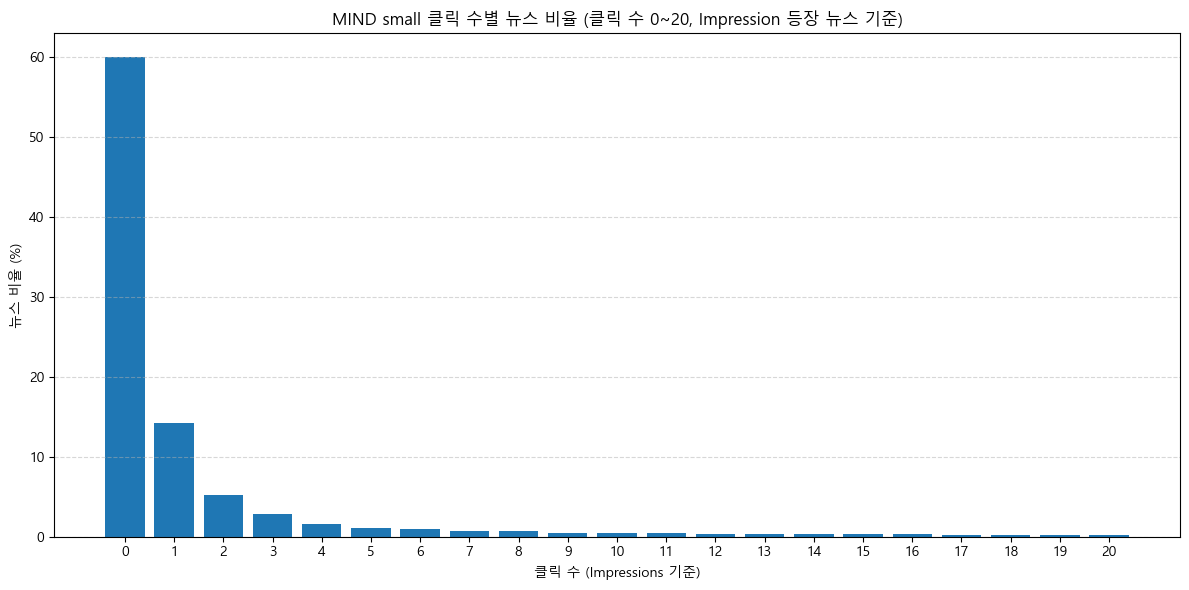

클릭 수 기준 (Impression에 등장한 뉴스 중)
클릭 0회: 13671개 뉴스 (60.04%)
클릭 1회: 3250개 뉴스 (14.27%)
클릭 2회: 1201개 뉴스 (5.27%)
클릭 3회: 637개 뉴스 (2.80%)
클릭 4회: 362개 뉴스 (1.59%)
클릭 5회: 248개 뉴스 (1.09%)
클릭 6회: 214개 뉴스 (0.94%)
클릭 7회: 153개 뉴스 (0.67%)


In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 폰트 설정
mpl.rc('font', family='Malgun Gothic')  # Windows 기준
mpl.rcParams['axes.unicode_minus'] = False

# Impression에 등장한 뉴스만 필터
impressed_news = small_click_result[small_click_result['total_impressions'] > 0]

# 클릭 수별 뉴스 수 카운트 (0~20만 필터)
click_counts = impressed_news['clicks_in_impressions'].value_counts().sort_index()
click_counts = click_counts[click_counts.index <= 20]

# 비율(%)로 변환
click_ratio = (click_counts / len(impressed_news)) * 100

# 막대그래프 그리기
plt.figure(figsize=(12, 6))
plt.bar(click_ratio.index, click_ratio.values)
plt.xlabel('클릭 수 (Impressions 기준)')
plt.ylabel('뉴스 비율 (%)')
plt.title('MIND small 클릭 수별 뉴스 비율 (클릭 수 0~20, Impression 등장 뉴스 기준)')
plt.xticks(range(0, 21))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 클릭 수 기준 비율 출력 (0~7)
print("클릭 수 기준 (Impression에 등장한 뉴스 중)")
for i in range(0, 8):
    count = click_counts.get(i, 0)
    percent = (count / len(impressed_news)) * 100
    print(f"클릭 {i}회: {count}개 뉴스 ({percent:.2f}%)")




In [26]:
zero_clicks = small_click_result[small_click_result['total_clicks'] == 0]
print("[클릭 수 0 뉴스 수]", len(zero_clicks))
print("[클릭 수 0 뉴스 예시]")
print(zero_clicks.head())


[클릭 수 0 뉴스 수] 12354
[클릭 수 0 뉴스 예시]
      news_id  clicks_in_history  clicks_in_impressions  total_clicks
35741  N28026                  0                      0             0
34776  N51193                  0                      0             0
38202   N4664                  0                      0             0
34779  N26330                  0                      0             0
35742  N12877                  0                      0             0


In [8]:
# 유저 데이터 전처리 large
import pandas as pd
from collections import Counter
from typing import Tuple

# 열 이름 정의
BEHAVIOR_COLUMNS = ['ImpressionID', 'UserID', 'Time', 'History', 'Impressions']

# 클릭된 뉴스 ID 추출 함수
def extract_clicks(df: pd.DataFrame, news_ids: pd.Series) -> pd.DataFrame:
    df = df.dropna(subset=['Impressions'])

    history_ids = df['History'].dropna().str.split().explode()
    impressions = df['Impressions'].str.split().explode().str.split('-')
    impression_df = pd.DataFrame(impressions.tolist(), columns=['news_id', 'clicked'])
    impression_counter_all = Counter(impression_df['news_id'])


    clicked_ids = impression_df[impression_df['clicked'] == '1']['news_id']

    history_counter = Counter(history_ids)
    impression_counter = Counter(clicked_ids)

    rows = []
    for news_id in news_ids:
        h_clicks = history_counter.get(news_id, 0)
        i_clicks = impression_counter.get(news_id, 0)
        total_impressions = impression_counter_all.get(news_id, 0)
        rows.append({
            'news_id': news_id,
            'clicks_in_history': h_clicks,
            'clicks_in_impressions': i_clicks,
            'total_clicks': h_clicks + i_clicks,
            'total_impressions': total_impressions
        })

    click_df = pd.DataFrame(rows)
    return click_df.sort_values(by='total_clicks', ascending=False)

# 저장 함수
def save_to_csv(df: pd.DataFrame, path: str):
    df.to_csv(path, index=False)

# 메인 실행
if __name__ == '__main__':
    train = pd.read_csv('download/MINDlarge_train/behaviors.tsv', sep='\t', names=BEHAVIOR_COLUMNS, header=0)
    dev = pd.read_csv('download/MINDlarge_dev/behaviors.tsv', sep='\t', names=BEHAVIOR_COLUMNS, header=0)
    combined = pd.concat([train, dev], ignore_index=True)

    train_news = pd.read_csv('download/MINDlarge_train/news.tsv', sep='\t', names=['NewsID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL', 'TitleEntities', 'AbstractEntities'])
    test_news = pd.read_csv('download/MINDlarge_dev/news.tsv', sep='\t', names=['NewsID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL', 'TitleEntities', 'AbstractEntities'])
    news_df = pd.concat([train_news, test_news], ignore_index=True)

    all_news_ids = news_df['NewsID'].dropna().unique()

    click_result = extract_clicks(combined, all_news_ids)

    print("[전체 뉴스 수 (impression 기준)]", click_result['total_impressions'].astype(bool).sum())
    print("[전체 뉴스 클릭 수]", small_click_result['total_clicks'].sum())
    print("[전체 클릭 뉴스 수]", len(click_result))
    total_click = click_result['total_clicks'].sum()
    print("[전체 뉴스 클릭 수]", total_click)

    print("------------------------------------------------------------")
    low_clicks = click_result[click_result['total_clicks'] < 5]
    print("[클릭 수 5 미만 뉴스 수]", len(low_clicks))
    print("[클릭 수 5 미만 뉴스 %]", round((len(low_clicks)/len(click_result)) * 100 , 3))
    print("------------------------------------------------------------")
    low_click = low_clicks['total_clicks'].sum()
    print("[클릭 수 5 미만 뉴스 총 클릭 수]", low_click)
    print("[클릭 수 5 미만 뉴스 %]", round(low_click/total_click * 100 , 3))

    print("------------------------------------------------------------")
    print("[전체 클릭 5미만 제외 뉴스 수]", len(click_result)-len(low_clicks))

    print("------------------------------------------------------------")
      # impression에 등장한 뉴스만 필터
    impressed_news = click_result[click_result['total_impressions'] > 0]

    # 이 중에서 클릭 수 5 미만인 뉴스
    low_click_impression = impressed_news[impressed_news['clicks_in_impressions'] < 5]

    print("[Impression에 등장한 뉴스 중 클릭 수 5 미만인 뉴스 수]", len(low_click_impression))
    print("[Impression에 등장한 뉴스 중 클릭 수 5 미만 뉴스 비율 %]", round((len(low_click_impression) / len(impressed_news)) * 100, 3))




[전체 뉴스 수 (impression 기준)] 29309
[전체 뉴스 클릭 수] 7817854
[전체 클릭 뉴스 수] 104151
[전체 뉴스 클릭 수] 89870480
------------------------------------------------------------
[클릭 수 5 미만 뉴스 수] 24690
[클릭 수 5 미만 뉴스 %] 23.706
------------------------------------------------------------
[클릭 수 5 미만 뉴스 총 클릭 수] 38800
[클릭 수 5 미만 뉴스 %] 0.043
------------------------------------------------------------
[전체 클릭 5미만 제외 뉴스 수] 79461
------------------------------------------------------------
[Impression에 등장한 뉴스 중 클릭 수 5 미만인 뉴스 수] 18985
[Impression에 등장한 뉴스 중 클릭 수 5 미만 뉴스 비율 %] 64.775


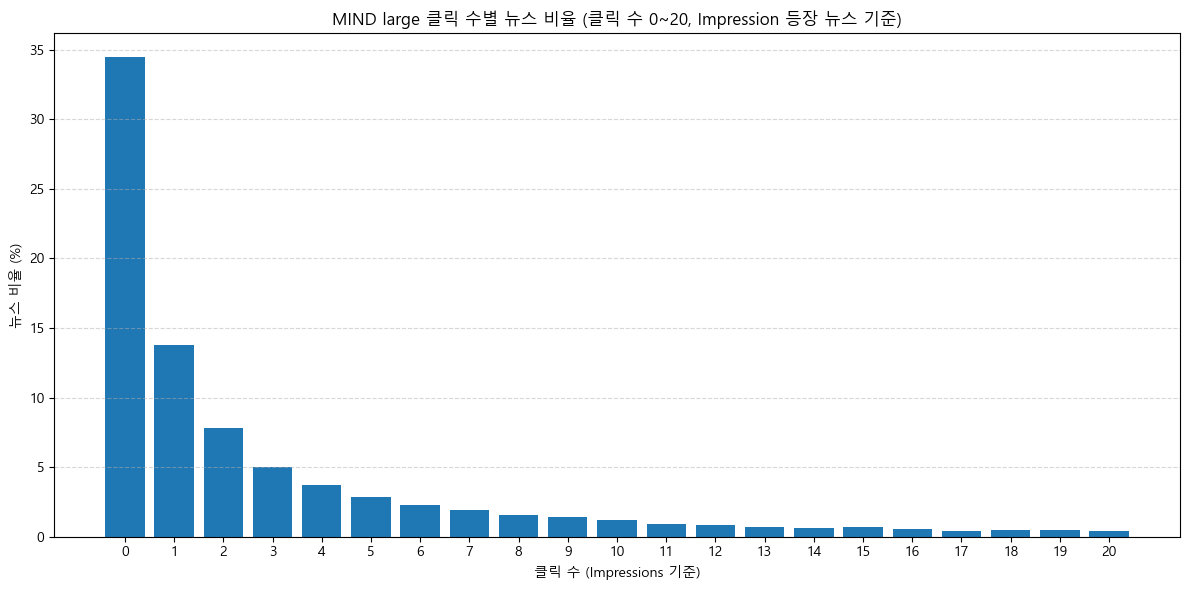

클릭 수 기준 (Impression에 등장한 뉴스 중)
클릭 0회: 10103개 뉴스 (34.47%)
클릭 1회: 4030개 뉴스 (13.75%)
클릭 2회: 2286개 뉴스 (7.80%)
클릭 3회: 1468개 뉴스 (5.01%)
클릭 4회: 1098개 뉴스 (3.75%)
클릭 5회: 832개 뉴스 (2.84%)
클릭 6회: 668개 뉴스 (2.28%)
클릭 7회: 566개 뉴스 (1.93%)


In [9]:
# Impression에 등장한 뉴스만 필터
impressed_news = click_result[click_result['total_impressions'] > 0]

# 클릭 수별 뉴스 수 카운트 (0~20만 필터)
click_counts = impressed_news['clicks_in_impressions'].value_counts().sort_index()
click_counts = click_counts[click_counts.index <= 20]

# 비율(%)로 변환
click_ratio = (click_counts / len(impressed_news)) * 100

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.bar(click_ratio.index, click_ratio.values)
plt.xlabel('클릭 수 (Impressions 기준)')
plt.ylabel('뉴스 비율 (%)')
plt.title('MIND large 클릭 수별 뉴스 비율 (클릭 수 0~20, Impression 등장 뉴스 기준)')
plt.xticks(range(0, 21))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 클릭 수 기준 비율 출력 (0~7)
print("클릭 수 기준 (Impression에 등장한 뉴스 중)")
for i in range(0, 8):
    count = click_counts.get(i, 0)
    percent = (count / len(impressed_news)) * 100
    print(f"클릭 {i}회: {count}개 뉴스 ({percent:.2f}%)")



In [14]:
impressed_news = small_click_result[small_click_result['total_impressions'] > 0]

total_impression_clicks = impressed_news['clicks_in_impressions'].sum()
print(f"[Impression 로그에 등장한 전체 클릭 수]: {total_impression_clicks}")
# 클릭 수 5 미만인 뉴스들
low_click_news = impressed_news[impressed_news['clicks_in_impressions'] < 5]

# 제거되는 클릭 수 합계
removed_clicks = low_click_news['clicks_in_impressions'].sum()
print(f"[클릭 수 5 미만인 뉴스 제거 시 손실되는 클릭 수]: {removed_clicks}")

# 전체 대비 비율
removed_ratio = (removed_clicks / total_impression_clicks) * 100
print(f"[제거되는 클릭 수 비율]: {removed_ratio:.2f}%")

[Impression 로그에 등장한 전체 클릭 수]: 347725
[클릭 수 5 미만인 뉴스 제거 시 손실되는 클릭 수]: 9011
[제거되는 클릭 수 비율]: 2.59%


In [19]:
impressed_news = click_result[click_result['total_impressions'] > 0]

total_impression_clicks = impressed_news['clicks_in_impressions'].sum()
print(f"[Impression 로그에 등장한 전체 클릭 수]: {total_impression_clicks}")
# 클릭 수 5 미만인 뉴스들
low_click_news = impressed_news[impressed_news['clicks_in_impressions'] < 5]

# 제거되는 클릭 수 합계
removed_clicks = low_click_news['clicks_in_impressions'].sum()
print(f"[클릭 수 5 미만인 뉴스 제거 시 손실되는 클릭 수]: {removed_clicks}")

# 전체 대비 비율
removed_ratio = (removed_clicks / total_impression_clicks) * 100
print(f"[제거되는 클릭 수 비율]: {removed_ratio:.2f}%")

[Impression 로그에 등장한 전체 클릭 수]: 3958496
[클릭 수 5 미만인 뉴스 제거 시 손실되는 클릭 수]: 17398
[제거되는 클릭 수 비율]: 0.44%


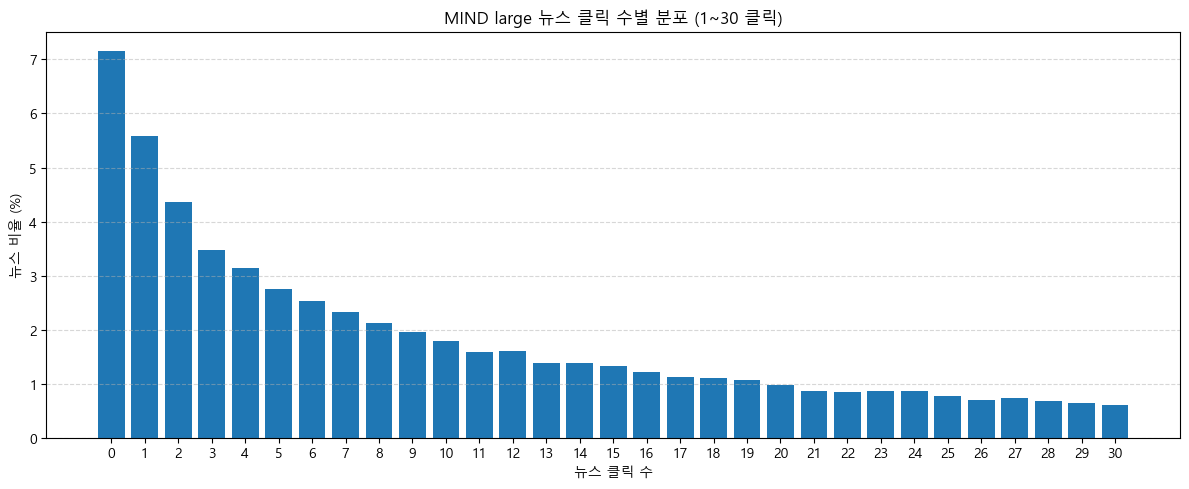

In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 폰트 설정
mpl.rc('font', family='Malgun Gothic')  # Windows 기준
mpl.rcParams['axes.unicode_minus'] = False

def plot_full_click_distribution(click_df: pd.DataFrame, max_clicks: int = 30):
    grouped = click_df['total_clicks'].value_counts().sort_index().reset_index()
    grouped.columns = ['click_count', 'news_count']

    total_news = grouped['news_count'].sum()
    grouped['percentage'] = (grouped['news_count'] / total_news) * 100

    grouped = grouped[grouped['click_count'] <= max_clicks]

    plt.figure(figsize=(12, 5))
    plt.bar(grouped['click_count'], grouped['percentage'])
    plt.title(f'MIND large 뉴스 클릭 수별 분포 (1~{max_clicks} 클릭)')
    plt.xlabel('뉴스 클릭 수')
    plt.ylabel('뉴스 비율 (%)')
    plt.xticks(grouped['click_count'])
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_full_click_distribution(click_result)

In [20]:
def get_click_0_to_5_percentage(click_df: pd.DataFrame) -> float:
    total_news = len(click_df)
    low_click_news = click_df[click_df['total_clicks'] < 5]
    percentage = (len(low_click_news) / total_news) * 100
    return round(percentage, 3)

def get_click_0_to_10_percentage(click_df: pd.DataFrame) -> float:
    total_news = len(click_df)
    low_click_news = click_df[click_df['total_clicks'] < 10]
    percentage = (len(low_click_news) / total_news) * 100
    return round(percentage, 3)

percent_0_to_5 = get_click_0_to_5_percentage(click_result)
print(f"[클릭 수 5 미만 뉴스 비율] {percent_0_to_5}%")

percent_0_to_10 = get_click_0_to_10_percentage(click_result)
print(f"[클릭 수 10 미만 뉴스 비율] {percent_0_to_10}%")


[클릭 수 5 미만 뉴스 비율] 23.706%
[클릭 수 10 미만 뉴스 비율] 35.387%


In [20]:
zero_clicks = click_result[click_result['total_clicks'] == 0]
print("[클릭 수 0 뉴스 수]", len(zero_clicks))
print("[클릭 수 0 뉴스 예시]")
print(zero_clicks.head())

[클릭 수 0 뉴스 수] 7451
[클릭 수 0 뉴스 예시]
        news_id  clicks_in_history  clicks_in_impressions  total_clicks  \
101043  N123283                  0                      0             0   
100491  N102841                  0                      0             0   
100433  N128455                  0                      0             0   
79813    N63371                  0                      0             0   
80939   N106658                  0                      0             0   

        total_impressions  
101043                  9  
100491                  1  
100433                 28  
79813                   4  
80939                   1  
